https://www.kaggle.com/competitions/test-task-for-ds-churn-prediction-2025-01

In [1]:
# підключення потрібних модулей

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# параметри виведення
pd.set_option("display.max_columns", 500)  # кількість колонок
pd.set_option("display.max_rows", 1000)  # кількість рядків
pd.set_option("display.max_colwidth", 300)  # ширина колонок
pd.set_option("display.precision", 5)  # кількість знаків після коми

# вимикаємо зайві попередження
import warnings

warnings.filterwarnings("ignore")

# друк всіх результатів в одній комірці а не тільки останнього
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
# завантаження ML-модулей

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.metrics import matthews_corrcoef as MCC

from sklearn.feature_selection import mutual_info_classif

In [3]:
from torch import nn
import datetime
from tqdm import tqdm

In [4]:
# шляхи до даних

data_dir = '/kaggle/input/test-task-for-ds-churn-prediction-2025-01/'
output_dir = '/kaggle/working/'
train_file = 'train.csv'
test_file = 'test.csv'

In [5]:
# завантаження та первинний огляд трейнового дата-сету
train_data = pd.read_csv(data_dir + train_file)

print(train_data.info())
print(train_data.describe())
print('\nКількість унікальних значень:\n', train_data.nunique())
print('\nКількість пустих значень:\n', train_data.isna().mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     24000 non-null  int64  
 1   ses_rec        24000 non-null  float64
 2   ses_rec_avg    24000 non-null  float64
 3   ses_rec_sd     24000 non-null  float64
 4   ses_rec_cv     24000 non-null  float64
 5   user_rec       24000 non-null  float64
 6   ses_n          24000 non-null  float64
 7   ses_n_r        24000 non-null  float64
 8   int_n          24000 non-null  float64
 9   int_n_r        24000 non-null  float64
 10  tran_n         24000 non-null  float64
 11  tran_n_r       24000 non-null  float64
 12  rev_sum        24000 non-null  float64
 13  rev_sum_r      24000 non-null  float64
 14  major_spend_r  24000 non-null  float64
 15  int_cat_n_avg  24000 non-null  float64
 16  int_itm_n_avg  24000 non-null  float64
 17  ses_mo_avg     24000 non-null  float64
 18  ses_mo

In [6]:
# завантаження та первинний огляд тестового дата-сету
test_data = pd.read_csv(data_dir + test_file)

print(test_data.shape)
print(test_data.info())
print('\nКількість пустих значень:\n', test_data.isna().mean())

(6000, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6000 non-null   int64  
 1   ses_rec        6000 non-null   float64
 2   ses_rec_avg    6000 non-null   float64
 3   ses_rec_sd     6000 non-null   float64
 4   ses_rec_cv     6000 non-null   float64
 5   user_rec       6000 non-null   float64
 6   ses_n          6000 non-null   float64
 7   ses_n_r        6000 non-null   float64
 8   int_n          6000 non-null   float64
 9   int_n_r        6000 non-null   float64
 10  tran_n         6000 non-null   float64
 11  tran_n_r       6000 non-null   float64
 12  rev_sum        6000 non-null   float64
 13  rev_sum_r      6000 non-null   float64
 14  major_spend_r  6000 non-null   float64
 15  int_cat_n_avg  6000 non-null   float64
 16  int_itm_n_avg  6000 non-null   float64
 17  ses_mo_avg     6000 non-null   float64
 1

In [ ]:
# оглядаємо розподіл

melted = train_data.melt()
g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value')
g.set_titles(col_template='{col_name}')
g.tight_layout()
plt.show()

In [ ]:
# оглядаємо матрицю кореляції

subset = train_data.drop(columns=['Unnamed: 0',])

corr_mtx = subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(10, 9))

sns.heatmap(corr_mtx,
            cmap='coolwarm',
            center=0,
            annot=False,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

plt.show();

### Висновки:
1. Дані тільки числові, без категоріальних.
2. Пустих значень немає ні в трейновому, ні в тестовому датасеті.
3. Нормальній розподіл тільки у двох ознак - треба використати PowerTransformer для нормалізації інших ознак
4. Ознака має тільки одне унікальне значення, то ж її можна виключити з датасету, т.я. вона не несе користної інформації
5. Можна додати декілька синтетичних ознак - кількість категорій, в яких мала місце активність користувача, а також загальна кількість активностей по каегоріям.

In [7]:
# очистка датасета та формування нових ознак

train_data['cat_act_num'] = train_data.loc[:, 'int_cat1_n':'int_cat24_n'].gt(0).astype('int').sum(axis='columns')
train_data['cat_act_sum'] = train_data.loc[:, 'int_cat1_n':'int_cat24_n'].sum(axis='columns')

drop_columns = ['Unnamed: 0', 'int_cat15_n'] # видаляємо індекс клієнта (унікальний ідентифікатор) та колонку int_cat15_n, яка містить єдине унікальне значення
train_data.drop(columns=drop_columns, inplace=True)
train_data.head(5)

,ses_rec,ses_rec_avg,ses_rec_sd,ses_rec_cv,user_rec,ses_n,ses_n_r,int_n,int_n_r,tran_n,tran_n_r,rev_sum,rev_sum_r,major_spend_r,int_cat_n_avg,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,time_to_tran,int_cat1_n,int_cat2_n,int_cat3_n,int_cat4_n,int_cat5_n,int_cat6_n,int_cat7_n,int_cat8_n,int_cat9_n,int_cat10_n,int_cat11_n,int_cat12_n,int_cat13_n,int_cat16_n,int_cat17_n,int_cat18_n,int_cat19_n,int_cat20_n,int_cat21_n,int_cat22_n,int_cat23_n,int_cat24_n,target_class,cat_act_num,cat_act_sum
0,13.0,2.50000,2.50000,1.00000,19.00000,3.00000,0.15789,4.0,1.33333,0.0,0.0,0.0,0.0,0.0,1.0,1.00000,7.33333,0.57735,15.00000,5.29150,0.00000,1.99444,1.49583,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,1,4
1,26.0,2.00000,0.00000,0.00000,32.00000,3.00000,0.09375,3.0,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,1.00000,7.00000,0.00000,12.33333,2.51661,0.33333,0.00000,0.00000,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,3,3
2,22.0,0.00000,0.00000,-1.00000,22.00000,2.00000,0.09091,3.0,1.50000,0.0,0.0,0.0,0.0,0.0,1.0,1.00000,7.00000,0.00000,13.50000,0.70711,1.00000,0.24167,0.16111,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,1,3
3,0.0,0.08234,0.08234,-0.67066,0.32934,2.16467,-0.58832,5.0,2.36277,0.0,0.0,0.0,0.0,0.0,1.0,1.94511,8.00000,0.00000,10.63723,4.47745,0.05489,0.99006,0.40609,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,5
4,24.0,0.00000,0.00000,-1.00000,24.00000,2.00000,0.08333,4.0,2.00000,0.0,0.0,0.0,0.0,0.0,1.0,1.50000,7.00000,0.00000,14.50000,0.70711,0.00000,5.18333,2.59167,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1,1,4


In [8]:
# розділення ознак та цільової змінної
X = train_data.copy()
y = X.pop("target_class")

In [9]:


mi = mutual_info_classif(X, y, 
                         discrete_features=True, 
                         random_state=42)

mi_scores = pd.Series(mi, name="MI Scores", index=X.columns).sort_values(ascending=False)

mi_scores

ses_ho_avg       0.37073
ses_ho_sd        0.36877
ses_n_r          0.33381
user_rec         0.29959
ses_rec          0.28961
time_to_int      0.28515
ses_rec_avg      0.28200
ses_len_avg      0.28134
int_n_r          0.22231
int_n            0.21893
ses_rec_cv       0.20868
ses_rec_sd       0.19511
ses_wknd_r       0.19288
int_itm_n_avg    0.18781
ses_mo_avg       0.12582
ses_n            0.11447
ses_mo_sd        0.10386
cat_act_sum      0.09095
int_cat_n_avg    0.03775
time_to_tran     0.02646
rev_sum_r        0.02635
rev_sum          0.02567
cat_act_num      0.01817
tran_n_r         0.01794
major_spend_r    0.01545
tran_n           0.01066
int_cat22_n      0.00791
int_cat16_n      0.00516
int_cat17_n      0.00453
int_cat19_n      0.00439
int_cat21_n      0.00282
int_cat20_n      0.00213
int_cat12_n      0.00202
int_cat18_n      0.00190
int_cat2_n       0.00184
int_cat1_n       0.00167
int_cat23_n      0.00111
int_cat3_n       0.00070
int_cat5_n       0.00068
int_cat24_n      0.00066


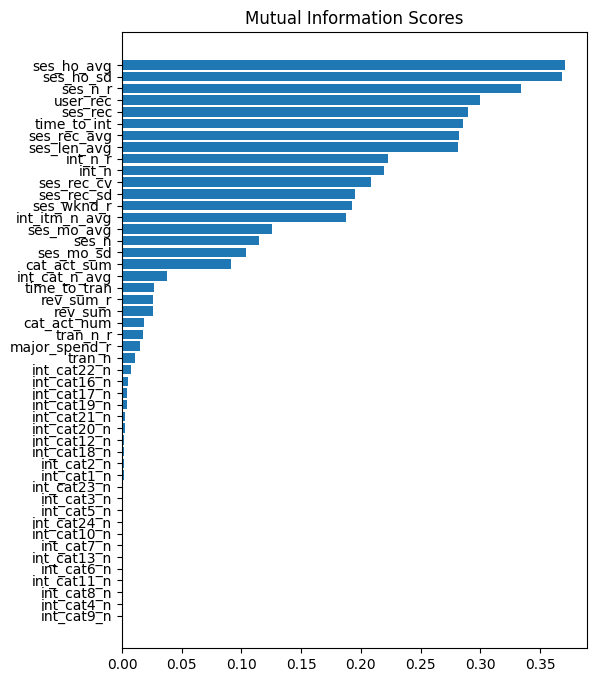

In [10]:
plt.figure(figsize=(6, 8))
mi_scores.sort_values(ascending=True, inplace=True)
plt.barh(np.arange(len(mi_scores)), mi_scores)
plt.yticks(np.arange(len(mi_scores)), mi_scores.index)
plt.title('Mutual Information Scores')
plt.show();

In [11]:
# зменшення кількості ознак

# оптимальні параметри (знайдені методом підбору)
# cardinal_trh = 10 # нічого не видаляємо
mi_important_feat_value = 0.09 # 0.001

# видаляємо малокардинальні ознаки
# drop_not_cardinal_columns_list = list(
#     X.nunique()[X.nunique().lt(cardinal_trh) == True].index
# )
# X.drop(columns=drop_not_cardinal_columns_list, inplace=True)

# видаляємо ознаки, прив'язані до дати формування датасету
# not_sense_cols_list = ["ses_rec", "user_rec", "ses_n_r"]
# X.drop(columns=not_sense_cols_list, inplace=True)

# видаляємо ознаки, які мають mi_scores менше 0.09
mi_important_feat_list = list(mi_scores[mi_scores < mi_important_feat_value].index)
# mi_important_feat_list
X.drop(columns=mi_important_feat_list, inplace=True)

X.shape
y.shape

(24000, 18)

(24000,)

### Створюємо нейромережу

In [12]:
# Making a PyTorch Dataset

import torch
from torch.utils.data import Dataset


class ChurnDataset(Dataset):

    def __init__(self, X, y, scale=True):
        self.X = X.values # from Pandas DataFrame to NumPy array
        self.y = y.values.reshape((y.shape[0], 1)) # зразу робимо решейп, щоб не робити це в кожному батчі датасету під час тренуванні моделі, як це наведено в конспекті. Це повинно трохи пришвидшити тренування.

        if scale:
            pt = PowerTransformer()
    #         self.X = pt.fit_transform(self.X)

    def __len__(self):
        #return size of a dataset
        return len(self.y)

    def __getitem__(self, idx):
        #supports indexing using dataset[i] to get the i-th row in a dataset

        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)

        return X, y

    
    # def __init__(self, X, y=None, scale=True):
    #     self.X = X.values  # from Pandas DataFrame to NumPy array
    #     # self.y = y

    #     self.y = y.values.reshape((y.shape[0], 1))
        
    #     # if y is not None:
    #     #     self.y = self.y.values.reshape(
    #     #         (y.shape[0], 1)
    #     #     )  # зразу робимо решейп, щоб не робити це в кожному батчі датасету під час тренуванні моделі, як це наведено в конспекті. Це повинно трохи пришвидшити тренування.

    #     if scale:
    #         pt = PowerTransformer()
    #         self.X = pt.fit_transform(self.X)

    # def __len__(self):
    #     # return size of a dataset
    #     return self.X.shape[0] # len(self.y)

    # def __getitem__(self, idx):
    #     # supports indexing using dataset[i] to get the i-th row in a dataset

    #     X = torch.tensor(self.X[idx], dtype=torch.float32)
        
    #     # if y is not None:
    #     #     y = torch.tensor(self.y[idx], dtype=torch.float32)

    #     y = torch.tensor(self.y[idx], dtype=torch.float32)

    #     return X, y

In [13]:
# ділимо дата-сет на тренувальні та тестові дані

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19200, 18), (4800, 18), (19200,), (4800,))

In [14]:
# перевіряємо, чи доступний GPU

is_cuda = torch.cuda.is_available()
print(f"GPU availability: {is_cuda}")

# Set the random seed for reproducible experiments
_ = torch.manual_seed(42)
if is_cuda:
    _ = torch.cuda.manual_seed(42)

# Specify a computing device
device = "cuda" if is_cuda else None
print(f"GPU device is {device}.")

GPU availability: True
GPU device is cuda.


In [15]:
# створюємо PyTorch-датасети

train_dataset = ChurnDataset(X_train, y_train)
test_dataset = ChurnDataset(X_test, y_test)

In [16]:
# створюємо завантажувачі батчів для сабдатасетів

batch_size = 32

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
      # shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=4,
     # shuffle=False,
)

In [17]:
# створюємо клас нейромережі


class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.layer1_dim = self.in_dim * 2 + 2
        self.layer2_dim = self.layer1_dim
        self.layer3_dim = self.layer2_dim
        self.layer4_dim = self.layer3_dim // 2

        super().__init__()

        self.features = torch.nn.Sequential(
            nn.Linear(self.in_dim, self.layer1_dim),
            torch.nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.layer1_dim, self.layer2_dim),
            torch.nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.layer2_dim, self.layer3_dim),
            torch.nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.layer3_dim, self.layer4_dim),
            torch.nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.layer4_dim, self.out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.features(x)
        return output

In [18]:
# тренуємо модель та перевіряємо точність для тренувальної та тестової частини для кожної епохи
# використовуємо чотири метрики оцінки: PyTorch-метрику MSELoss (критерій втрат для градієнтного спуску), sklearn-метрики MSE, MAE, R2-score

from torch import nn
import datetime
from tqdm import tqdm

start_time = datetime.datetime.now()

# Initialize the model
model = LinearModel(in_dim=X_train.shape[1], out_dim=1).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

best_val_loss = float('inf')
patience = 100
counter = 0

train_losses = []
train_mcc = []

test_losses = []
test_mcc = []

# Train the model

num_epochs = 500 # 500

for epoch in tqdm(range(num_epochs)):

    # Train step

    _ = model.train()

    y_pred_train = []

    for data in train_dataloader:

        # Get and prepare inputs
        inputs, targets = data

        if is_cuda:
            inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(
                non_blocking=True
            )

        # inputs, targets = inputs.float(), targets.float() # - зробили це раніше
        # targets = targets.reshape((targets.shape[0], 1)) # - зробили це раніше

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(outputs)
        # print(type(outputs))
        
        y_pred_train.extend(outputs.cpu().detach().squeeze().numpy().round())
        # print(y_pred_train[0])

    epoch_loss = loss.cpu().detach().numpy()
    epoch_mcc = MCC(y_train, y_pred_train)

    train_losses.append(epoch_loss)
    train_mcc.append(epoch_mcc)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, MCC: {epoch_mcc:.4f}"
        )


    # Eval step

    _ = model.eval()

    y_pred_test = []

    with torch.no_grad():

        for data in test_dataloader:

            # Get and prepare inputs
            inputs, targets = data

            if is_cuda:
                inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(
                    non_blocking=True
                )

            # inputs, targets = inputs.float(), targets.float() # - зробили це раніше
            # targets = targets.reshape((targets.shape[0], 1)) # - зробили це раніше

            # Forward pass
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)

            # No backward pass
            y_pred_test.extend(outputs.cpu().detach().squeeze().numpy().round())

        test_losses.append(val_loss.cpu().detach().numpy())
        test_mcc.append(MCC(y_test, y_pred_test))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
             
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break 

print(f"Train time = {datetime.datetime.now() - start_time}")

  2%|▏         | 9/500 [00:24<21:34,  2.64s/it]

Epoch [10/500], Loss: 0.3969, MCC: 0.1006


  4%|▍         | 19/500 [00:50<20:57,  2.61s/it]

Epoch [20/500], Loss: 0.3958, MCC: 0.1225


  6%|▌         | 29/500 [01:17<20:33,  2.62s/it]

Epoch [30/500], Loss: 0.3715, MCC: 0.2338


  8%|▊         | 39/500 [01:43<20:31,  2.67s/it]

Epoch [40/500], Loss: 0.2397, MCC: 0.6593


 10%|▉         | 49/500 [02:10<20:11,  2.69s/it]

Epoch [50/500], Loss: 0.2846, MCC: 0.7447


 12%|█▏        | 59/500 [02:37<19:53,  2.71s/it]

Epoch [60/500], Loss: 0.2765, MCC: 0.7729


 14%|█▍        | 69/500 [03:03<18:58,  2.64s/it]

Epoch [70/500], Loss: 0.2632, MCC: 0.7977


 16%|█▌        | 79/500 [03:29<18:35,  2.65s/it]

Epoch [80/500], Loss: 0.2676, MCC: 0.8090


 18%|█▊        | 89/500 [03:56<18:14,  2.66s/it]

Epoch [90/500], Loss: 0.3828, MCC: 0.8090


 20%|█▉        | 99/500 [04:22<17:21,  2.60s/it]

Epoch [100/500], Loss: 0.3056, MCC: 0.8120


 22%|██▏       | 109/500 [04:48<17:09,  2.63s/it]

Epoch [110/500], Loss: 0.3267, MCC: 0.8179


 24%|██▍       | 119/500 [05:15<17:01,  2.68s/it]

Epoch [120/500], Loss: 0.2817, MCC: 0.8196


 26%|██▌       | 129/500 [05:41<16:12,  2.62s/it]

Epoch [130/500], Loss: 0.3432, MCC: 0.8241


 28%|██▊       | 139/500 [06:07<15:30,  2.58s/it]

Epoch [140/500], Loss: 0.2889, MCC: 0.8206


 30%|██▉       | 149/500 [06:33<15:23,  2.63s/it]

Epoch [150/500], Loss: 0.2815, MCC: 0.8280


 32%|███▏      | 159/500 [06:59<14:47,  2.60s/it]

Epoch [160/500], Loss: 0.2953, MCC: 0.8321


 34%|███▍      | 169/500 [07:25<14:38,  2.65s/it]

Epoch [170/500], Loss: 0.3042, MCC: 0.8357


 36%|███▌      | 179/500 [07:53<14:35,  2.73s/it]

Epoch [180/500], Loss: 0.3025, MCC: 0.8368


 38%|███▊      | 189/500 [08:19<13:36,  2.63s/it]

Epoch [190/500], Loss: 0.3066, MCC: 0.8411


 40%|███▉      | 199/500 [08:45<13:14,  2.64s/it]

Epoch [200/500], Loss: 0.2790, MCC: 0.8411


 42%|████▏     | 209/500 [09:12<12:49,  2.65s/it]

Epoch [210/500], Loss: 0.2708, MCC: 0.8452


 44%|████▍     | 219/500 [09:38<12:16,  2.62s/it]

Epoch [220/500], Loss: 0.2296, MCC: 0.8425


 46%|████▌     | 229/500 [10:05<12:01,  2.66s/it]

Epoch [230/500], Loss: 0.2829, MCC: 0.8440


 48%|████▊     | 239/500 [10:31<11:19,  2.60s/it]

Epoch [240/500], Loss: 0.3132, MCC: 0.8482


 50%|████▉     | 249/500 [10:57<10:56,  2.62s/it]

Epoch [250/500], Loss: 0.2835, MCC: 0.8448


 52%|█████▏    | 259/500 [11:24<10:34,  2.63s/it]

Epoch [260/500], Loss: 0.3345, MCC: 0.8430


 54%|█████▍    | 269/500 [11:50<10:07,  2.63s/it]

Epoch [270/500], Loss: 0.2802, MCC: 0.8464


 56%|█████▌    | 279/500 [12:16<09:34,  2.60s/it]

Epoch [280/500], Loss: 0.3070, MCC: 0.8476


 58%|█████▊    | 289/500 [12:43<09:49,  2.79s/it]

Epoch [290/500], Loss: 0.2746, MCC: 0.8492


 60%|█████▉    | 299/500 [13:09<08:46,  2.62s/it]

Epoch [300/500], Loss: 0.3074, MCC: 0.8473


 62%|██████▏   | 309/500 [13:36<08:20,  2.62s/it]

Epoch [310/500], Loss: 0.2648, MCC: 0.8488


 62%|██████▏   | 310/500 [13:41<08:23,  2.65s/it]

Early stopping at epoch 310
Train time = 0:13:42.659781


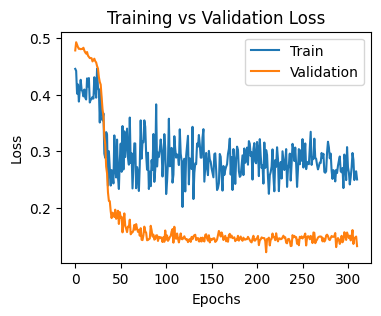

In [19]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Validation")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show();

<Figure size 400x300 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'MCC')

Text(0.5, 1.0, 'Training vs Validation Metric - MCC')

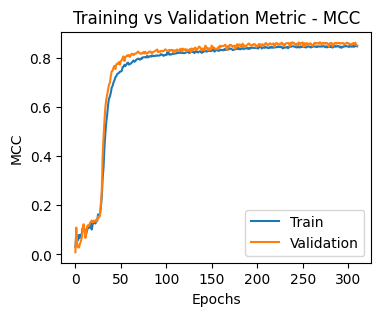

In [20]:
plt.figure(figsize=(4, 3))
plt.plot(train_mcc, label="Train")
plt.plot(test_mcc, label="Validation")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("MCC")
plt.title("Training vs Validation Metric - MCC")
plt.show()

In [21]:
torch.save(model.state_dict(), 'last_model.pth')

In [27]:
# Initialize the model
model = LinearModel(in_dim=X_train.shape[1], out_dim=1).to(device)
criterion = nn.BCELoss().to(device)

# Завантажте стан моделі
model.load_state_dict(torch.load("best_model.pth"))
# model.load_state_dict(torch.load("last_model.pth"))

<All keys matched successfully>

In [28]:
# Full dataset accuracy test

_ = model.eval()

with torch.no_grad():

    full_dataset = ChurnDataset(X, y)
    inputs, targets = full_dataset[:, :]

    if is_cuda:
        inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(
            non_blocking=True
        )

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # accuracy calculating
    y_pred = outputs.cpu().detach().squeeze().numpy().round()
    print(
        f"Full dataset: Loss={loss.cpu().detach().numpy():.4f}, MCC={MCC(y, y_pred):.4f}"
    )

Full dataset: Loss=0.1564, MCC=0.8604


In [29]:
test_data["cat_act_num"] = (
    test_data.loc[:, "int_cat1_n":"int_cat24_n"].gt(0).astype("int").sum(axis="columns")
)
test_data["cat_act_sum"] = test_data.loc[:, "int_cat1_n":"int_cat24_n"].sum(
    axis="columns"
)

# drop_columns = ['Unnamed: 0', 'int_cat15_n']
X_pred = test_data.drop(
    columns=drop_columns,
)
# X_pred = X_pred.drop(columns=drop_not_cardinal_columns_list)
X_pred.drop(columns=mi_important_feat_list, inplace=True)

In [30]:
_ = model.eval()

with torch.no_grad():

    pred_dataset = ChurnDataset(X_pred, pd.Series(np.zeros((X_pred.shape[0]))))
    inputs, _ = pred_dataset[:, :]

    if is_cuda:
        inputs = inputs.cuda(non_blocking=True)
        # targets = targets.cuda(non_blocking=True)

    # Forward pass
    outputs = model(inputs)
    # loss = criterion(outputs, targets)

    # accuracy calculating
    y_pred = outputs.cpu().detach().squeeze().numpy().round()
    # print(f"Full dataset: Loss={loss.cpu().detach().numpy():.4f}, MCC={MCC(y, y_pred):.4f}")

In [31]:
# зберіганеня предікту в файл для сабмішену в кагл
output = pd.concat([test_data["Unnamed: 0"], pd.Series(y_pred)], axis=1)
output.columns = ["ID", "target"]

output.to_csv(output_dir + "submission.csv", index=False,)

In [32]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      6000 non-null   int64  
 1   target  6000 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 70.4 KB


### The end of NN